In [233]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

# import warnings
# warnings.filterwarnings('ignore')

from sklearn.calibration import calibration_curve, CalibrationDisplay

In [234]:
# ift6758/data/milestone2/q5_plots
import sys
sys.path.append('../ift6758/data/milestone2')
from q5_plots import read_dataset,\
                     get_prob,\
                     get_percentile,\
                     get_rate,\
                     plot_models

# Question 5.1

In [235]:
#########################################################
# 5.1 Simple XGboost
#########################################################

def q5_1(X, y, features=['Distance from Net']):
    '''
    reference: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    '''

    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.20, random_state=50)

    # Fit model no training data
    model = xgb.XGBClassifier()
    # breakpoint()
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_test_pred = model.predict(X_test)
    y_test = y_test.to_numpy().flatten()
    
    # Evaluate predictions
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Predict the probability of each test sample being of a given class
    X_test_pred_proba = model.predict_proba(X_test)
    # print(X_test_pred_proba)
    
    return X_test_pred_proba, y_test
    
# train(X,y)

In [236]:
X,y = read_dataset()
features = ['Distance from Net']
X_test_pred_proba, y_test = q5_1(X,y, features)

[14:29:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.39%


In [237]:
from matplotlib.gridspec import GridSpec

feature_color_dict = {
    1: [['Distance from Net'], 'r'],
    2: [['Angle from Net'], 'g'],
    3: [['Distance from Net', 'Angle from Net'], 'plum'],
    4: ['Random baseline', 'b']
    }

In [238]:
def plot_roc(X, y, feature_color_dict):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            probs, y_test = q5_1(X, y, features)
            is_goal_probs = probs[:, 1]                
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'

        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
            curve_label = 'Random Baseline'
        
        fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal_probs)
        
        roc_auc = metrics.auc(fpr, tpr)
        
        plt.plot(fpr, 
                 tpr, 
                 color=color, 
                 label=f'{curve_label} '+'AUC = %0.2f' % roc_auc)      
    
    plt.axis([0, 1, 0, 1])    
        
    plt.title('ROC Curves')
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    
# plot_roc(feature_color_dict)

In [239]:
def get_rate(df, function_type='goal_rate'):
    '''
    Divide the sorted df into 10 bins, each two adjacent bins have a difference of 10 on percentile.
    As we noticed, the percentile ranges from 0 to 99.99, we set bin range from 0 to 100, 
    so, there are 10 bins: [0:10], [10:20], ..., [90:100].
    Given function type, calculates the corresponding rate. 
    
    :params df: A sorted percentile df, calculated by get_percentile().
    :params function_type: Function type. Default value 'goal_rate'. 
                           Another option is 'cumulative_rate'.
    
    :return goal_rate_df: A df has shape (10, 2). First column is rate, second column is bin index. 
    '''
    
    # In goal_rate function, the list should have a length of 10, 
    # each item is the goal rate of that bin. 
    # For example, if there are 5000 records have percentiles between 0 and 10, 
    # and there are 250 goals, the goal rate is 250/5000=0.05.
    # So, rate_list[0] is 0.05
    rate_list = []
    
    # Find total number of goals
    total_goals = df['Is Goal'].value_counts()[1]
    
    cumulative_counts = 0

    i = 0
    i_list = []
    
    # 91 is the lower bound of last bin
    while i<92:
        i_list.append(i)

        # current bin size
        lower_bound = i
        upper_bound = (i+10)

        # find all records that have percentiles fall in this range
        rows = df[(df['Percentile']>=lower_bound) &
                  (df['Percentile']<upper_bound)]
        
        # count the number of goals
        goals = rows['Is Goal'].value_counts()[1]

        shots = rows.shape[0]

        if function_type == 'goal_rate':
            rate = goals/shots
            
        elif function_type == 'cumulative_rate':
            cumulative_counts += goals
            rate = (cumulative_counts)/total_goals

        rate_list.append(rate)

        i+=10

    rate_list = [i*100 for i in rate_list]    
    
    # Combine goal rate list and percentile list into one df
    rate_df = pd.DataFrame(list(zip(rate_list, i_list)),\
                                columns=['Rate', 'Percentile'])
    
    return rate_df

# goal_rate_df = get_rate(perc_df)
# goal_rate_df

In [240]:
def get_percentile(X, y, probs, features=['Distance from Net']):
    '''
    Return a df that has four columns:
        * 'index': index in y_test.
        * 'Goal prob': Goal probability.
        * 'Is Goal': 0 means not goal; 1 means goal.
        * 'Percentile': Calculated percentile, range from 0.00 to 99.99.
    The df is sorted by 'Percentile'.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)

    # Create a df for shot probabilities
    probs_df = pd.DataFrame(probs)
    probs_df = probs_df.rename(columns={0: "Not Goal prob", 1: "Goal prob"})

    # Concatenate 'Goal Probability' and 'Is Goal' into one df. Each column has values: 0 and 1. 
    df = pd.concat([probs_df["Goal prob"].reset_index(drop=True),\
                    y_test["Is Goal"].reset_index(drop=True)],axis=1)

    # Add 'Percentile' column
    percentile_series=df['Goal prob'].rank().apply(lambda x: 100.0*(x-1)/df.shape[0])
    df['Percentile'] = percentile_series

    # Sort the df by the value of percentile. Min is 0.0000, max is 99.9967
    df = df.sort_values(by=['Percentile'])
    df = df.reset_index()
    
    return df

In [241]:
def plot_goal_rate(X, y, feature_color_dict):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            probs, y_test = q5_1(X, y, features)
            is_goal_probs = probs[:, 1]
            perc_df = get_percentile(X, y, probs, features)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'
            
        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
            no_goal_prob = np.array([(1 - i) for i in is_goal_probs])
            probs = np.column_stack((is_goal_probs, no_goal_prob))
            perc_df = get_percentile(X, y, probs)
            curve_label = 'Random Baseline'
            
        goal_rate_df = get_rate(perc_df, function_type='goal_rate')
        plt.plot(
            goal_rate_df['Percentile']/100,
            goal_rate_df['Rate']/100,
            label=curve_label,
            color=color
        )   
       
    plt.title('Goal rate')
    plt.legend()
    plt.ylabel('Goal Rate')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)

In [242]:
def plot_cumulative_rate(X, y, feature_color_dict):
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]

        if features != 'Random baseline':
            probs, y_test = q5_1(X, y, features)
            is_goal_probs = probs[:,1]   
            perc_df = get_percentile(X, y, probs, features)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'

        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0,1,is_goal_probs.shape[0])
            no_goal_prob = np.array([(1-i) for i in is_goal_probs])
            probs = np.column_stack((is_goal_probs, no_goal_prob))
            perc_df = get_percentile(X, y, probs)
            curve_label = 'Random Baseline'
            
        cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 
        
        plt.plot(
            cumulative_rate['Percentile']/100,
            cumulative_rate['Rate']/100,
            label=curve_label,
            color=color,
        )  
   
    # plt.title('Cumulative goal rate')
    plt.title('Cumulative Proportion of Goals')
    plt.legend()
    plt.ylabel('Cumulative Proportion of Goals')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)

In [243]:
def plot_calibration(X, y, feature_color_dict):
    '''
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    '''

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.20, random_state=50)
            clf = xgb.XGBClassifier()
            # breakpoint()
            clf.fit(X_train, y_train)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'
        
        # Random baseline
        else:
            goal_prob = np.random.uniform(0, 1, X_test.shape[0])
            
            # Value is 1 if goal_prob is greater than 0.5, 0 otherwise.
            random_y_test = np.zeros((goal_prob.shape[0],1))
            random_y_test[:,][np.where(goal_prob>0.5)]=1
            curve_label = 'Random Baseline'
        
        display = CalibrationDisplay.from_estimator(
                clf,
                X_test,
                y_test,
                n_bins=50,
                ax=ax_calibration_curve,
                color=color,
                label=curve_label
            )
    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.ylabel('Fraction of positives')
    plt.xlabel('Mean predicted probability')
    plt.show()

[14:29:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.39%
[14:29:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.40%
[14:29:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:lo

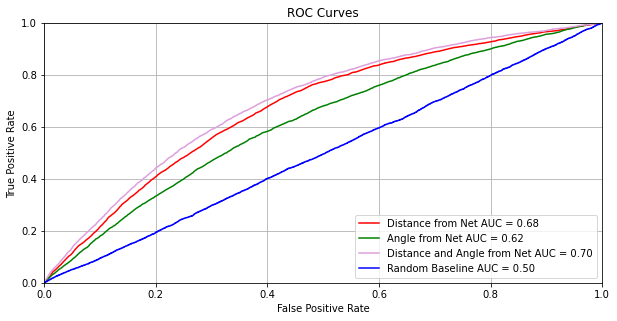

[14:30:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.39%
[14:30:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.40%
[14:30:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:lo

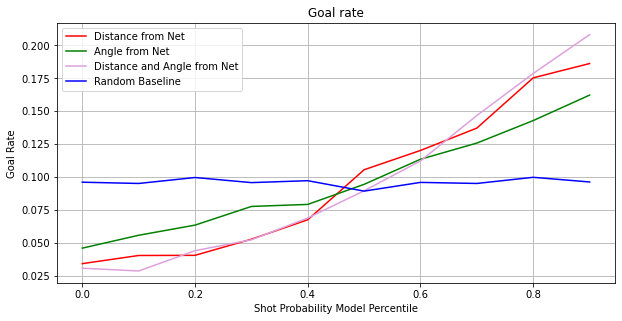

[14:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.39%
[14:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.40%
[14:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:lo

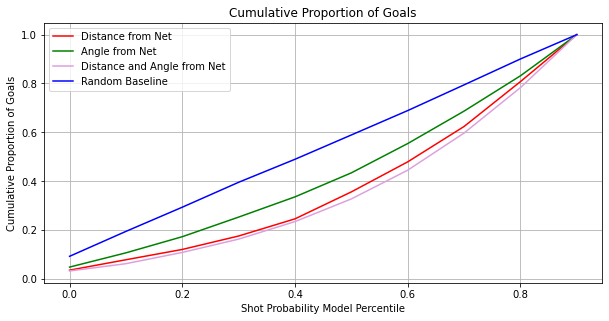

[14:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

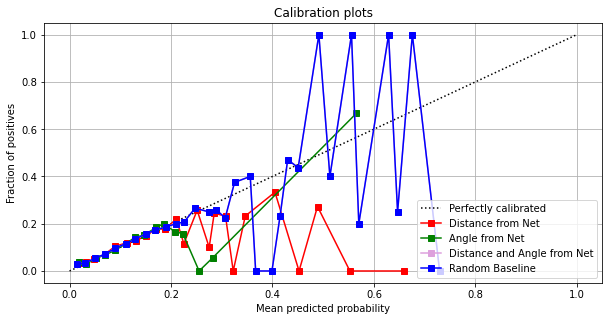

In [244]:
def plot5_1(X, y):

    # feature_color_dict = {
    #     1: [['Distance from Net'], 'r'],
    #     2: [['Angle from Net'], 'g'],
    #     3: [['Distance from Net', 'Angle from Net'], 'plum'],
    #     4: ['Random baseline', 'b']
    #     }
    
    #--------------------------------------
    # ROC
    #--------------------------------------
    plot_roc(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Goal rate
    #--------------------------------------  
    plot_goal_rate(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Cumulative proportion of goals
    #--------------------------------------  
    plot_cumulative_rate(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Calibration
    #-------------------------------------- 
    plot_calibration(X, y, feature_color_dict)
    plt.show()

    
plot5_1(X, y)

In [245]:
# plot_models(X, y, model, y_test_pred, y_test, y_test_pred_proba)

In [246]:
# train(X,y, features=['Angle from Net'])

In [247]:
y.shape

(311106, 1)

In [248]:
# X,y = read_dataset()
# plot_models(X, y, 'xgb')

In [249]:
# plot_models(X, y, 'xgb', features=['Angle from Net'])

In [250]:
# plot_models(X, y, 'xgb', features=['Distance from Net', 'Angle from Net'])

# Question 5.2

In [259]:
#########################################################
# 5.2 XGBoost + hyperparameter tuning
# ref:
# - https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d
#########################################################

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import time

def q5_2(X, y):
    
    # Read CSV files
    dataset = pd.read_csv('/Users/sunjiaao/Courses/IFT6758/m2_CSV_data/all_data_q4_categorical.csv')

    # Separate features and labels 
    X = dataset[['eventIdx', 'game_id', 'Game Seconds', 'Game Period', 'X-Coordinate', 'Y-Coordinate',
               'Shot Distance', 'Shot Angle', 'Shot Type', 'Was Net Empty', 'Last Event Type', 'Last X-Coordinate',
               'Last Y-Coordinate', 'Time from Last Event (seconds)', 'Distance from Last Event', 'Is Rebound',
               'Change in Shot Angle', 'Speed']]
    y = dataset[['Is Goal']]

    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50)
    
    # https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
    params = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 6, 10],
              'learning_rate': [0.01, 0.05, 0.1],# 0.2, 0.5, 0.7],
              'booster': ['gbtree', 'gblinear', 'dart'],
              
              # 'tree_method': [],  # just keep this as commented out to use its default value
              # 'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
              # 'min_child_weight': [],
              # 'max_delta_step': [],
              # 'subsample': [],
              # 'colsample_bytree': [0.3, 0.7],
              # 'colsample_bylevel': [0.3, 0.7],
              # 'colsample_bynode': [0.3, 0.7],
              # 'reg_alpha',
              # 'reg_lambda',
    }
    
    model = xgb.XGBClassifier()
    
    # When cv is not set, it defaults to 5-fold cross validation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    clf = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       refit=True,
                       verbose=4)
    
    clf.fit(X_train, y_train)

    print("Best parameters:", clf.best_params_)
    print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
    
    y_pred = clf.predict(X_test)
    # print('y_pred', y_pred)
    
    # Evaluate predictions
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Predict the probability of each test sample being of a given class
    X_test_pred_proba = clf.predict_proba(X_test)
    # print(X_test_pred_proba)
    
    return X_test_pred_proba, y_test, clf, X_test

# start_time = time.time()
# q5_2(X, y)
# print("--- %s seconds ---" % (time.time() - start_time))


#     ###############################################################
#     # Irene xiao jie jie below
#     ###############################################################
    
#     #setting grid of selected parameters for iteration
#     param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#                   'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
#                   'max_depth': [5,6,7,8,9,10,11,12,13,14],
#                   'n_estimators': [50,65,80,100,115,130,150],
#                   'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#                   'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
    
#     #dictionary for collecting results
#     results_dict = {}

#     #obtaining default parameters by calling .fit() to XGBoost model instance
#     xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
#                               booster='gbtree',
#                               eval_metric='auc',
#                               tree_method='hist',
#                               grow_policy='lossguide',
#                               use_label_encoder=False)
#     xgbc0.fit(X_train , y_train)

#     #extracting default parameters from benchmark model
#     default_params = {}
#     gparams = xgbc0.get_params()

#     #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
#     for key in gparams.keys():
#         gp = gparams[key]
#         default_params[key] = [gp]

#     #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#     #However, cross-validation is still executed
#     clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
#     clf0.fit(X_train, y_train.values.ravel())

#     #results dataframe
#     df = pd.DataFrame(clf0.cv_results_)

#     #predictions - inputs to confusion matrix
#     train_predictions = clf0.predict(X_train)
#     test_predictions = clf0.predict(X_test)
#     unseen_predictions = clf0.predict(df_test.iloc[:,1:])

#     #confusion matrices
#     cfm_train = confusion_matrix(y_train, train_predictions)
#     cfm_test = confusion_matrix(y_test, test_predictions)
#     cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#     #accuracy scores
#     accs_train = accuracy_score(y_train, train_predictions)
#     accs_test = accuracy_score(y_test, test_predictions)
#     accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)

#     #F1 scores for each train/test label
#     f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
#     f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
#     f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
#     f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
#     f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
#     f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)

#     #Area Under the Receiver Operating Characteristic Curve
#     test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
#     unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf0.predict_proba(df_test.iloc[:,1:])[:,1])

#     #best parameters
#     bp = clf0.best_params_

#     #storing computed values in results dictionary
#     results_dict['xgbc0'] = {'iterable_parameter': np.nan,
#                              'classifier': deepcopy(clf0),
#                              'cv_results': df.copy(),
#                              'cfm_train': cfm_train,
#                              'cfm_test': cfm_test,
#                              'cfm_unseen': cfm_unseen,
#                              'train_accuracy': accs_train,
#                              'test_accuracy': accs_test,
#                              'unseen_accuracy': accs_unseen,
#                              'train F1-score label 1': f1s_train_p1,
#                              'train F1-score label 0': f1s_train_p0,
#                              'test F1-score label 1': f1s_test_p1,
#                              'test F1-score label 0': f1s_test_p0,
#                              'unseen F1-score label 1': f1s_unseen_p1,
#                              'unseen F1-score label 0': f1s_unseen_p0,
#                              'test roc auc score': test_ras,
#                              'unseen roc auc score': unseen_ras,
#                              'best_params': bp}
    
#     print(results_dict)

In [260]:
# start_time = time.time()
# q5_2(X, y)
# print("--- %s seconds ---" % (time.time() - start_time))

In [261]:
def plot_roc_5_2(X, y, probs, y_test):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    # All Features
    # probs, y_test = q5_2(X, y)
    is_goal_probs = probs[:, 1]                
    curve_label = 'All Features'

    fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal_probs)

    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, 
             tpr, 
             # color=color, 
             label=f'{curve_label} '+'AUC = %0.2f' % roc_auc)  
    
    # Random Baseline
    is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
    curve_label = 'Random Baseline'

    fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal_probs)

    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, 
             tpr, 
             # color=color, 
             label=f'{curve_label} '+'AUC = %0.2f' % roc_auc)  
    
    plt.axis([0, 1, 0, 1])    
        
    plt.title('ROC Curves')
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)

In [262]:
def get_percentile_5_2(X, y, probs):
    '''
    Return a df that has four columns:
        * 'index': index in y_test.
        * 'Goal prob': Goal probability.
        * 'Is Goal': 0 means not goal; 1 means goal.
        * 'Percentile': Calculated percentile, range from 0.00 to 99.99.
    The df is sorted by 'Percentile'.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=50)

    # Create a df for shot probabilities
    probs_df = pd.DataFrame(probs)
    probs_df = probs_df.rename(columns={0: "Not Goal prob", 1: "Goal prob"})

    # Concatenate 'Goal Probability' and 'Is Goal' into one df. Each column has values: 0 and 1. 
    df = pd.concat([probs_df["Goal prob"].reset_index(drop=True),\
                    y_test["Is Goal"].reset_index(drop=True)],axis=1)

    # Add 'Percentile' column
    percentile_series=df['Goal prob'].rank().apply(lambda x: 100.0*(x-1)/df.shape[0])
    df['Percentile'] = percentile_series

    # Sort the df by the value of percentile. Min is 0.0000, max is 99.9967
    df = df.sort_values(by=['Percentile'])
    df = df.reset_index()
    
    return df

In [263]:
def plot_goal_rate_5_2(X, y, probs, y_test):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    # All features
    # probs, y_test = q5_2(X, y)
    is_goal_probs = probs[:, 1]
    perc_df = get_percentile_5_2(X, y, probs)
    curve_label = 'All Features'
   
    goal_rate_df = get_rate(perc_df, function_type='goal_rate')
    plt.plot(
        goal_rate_df['Percentile']/100,
        goal_rate_df['Rate']/100,
        label=curve_label,
        # color=color
    )  
    
    # Random baseline
    is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
    no_goal_prob = np.array([(1 - i) for i in is_goal_probs])
    probs = np.column_stack((is_goal_probs, no_goal_prob))
    perc_df = get_percentile_5_2(X, y, probs)
    curve_label = 'Random Baseline'
            
    goal_rate_df = get_rate(perc_df, function_type='goal_rate')
    plt.plot(
        goal_rate_df['Percentile']/100,
        goal_rate_df['Rate']/100,
        label=curve_label,
        # color=color
    )   
    
    plt.title('Goal rate')
    plt.legend()
    plt.ylabel('Goal Rate')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)

In [264]:
def plot_cumulative_rate_5_2(X, y, probs, y_test):
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    # All Features
    # probs, y_test = q5_2(X, y)
    is_goal_probs = probs[:,1]   
    perc_df = get_percentile_5_2(X, y, probs)
    curve_label = 'All Features'

    cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 

    plt.plot(
        cumulative_rate['Percentile']/100,
        cumulative_rate['Rate']/100,
        label=curve_label,
        # color=color,
    )  
    
    # Random baseline
    is_goal_probs = np.random.uniform(0,1,is_goal_probs.shape[0])
    no_goal_prob = np.array([(1-i) for i in is_goal_probs])
    probs = np.column_stack((is_goal_probs, no_goal_prob))
    perc_df = get_percentile_5_2(X, y, probs)
    curve_label = 'Random Baseline'
            
    cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 

    plt.plot(
        cumulative_rate['Percentile']/100,
        cumulative_rate['Rate']/100,
        label=curve_label,
        # color=color,
    )
   
    # plt.title('Cumulative goal rate')
    plt.title('Cumulative Proportion of Goals')
    plt.legend()
    plt.ylabel('Cumulative Proportion of Goals')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)

In [265]:
def plot_calibration_5_2(X, y, X_test, y_test, clf):
    '''
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    '''

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    # # All Features
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
    # clf = xgb.XGBClassifier()
    # # breakpoint()
    # clf.fit(X_train, y_train)
    curve_label = 'All Features'
        
    display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=50,
            ax=ax_calibration_curve,
            # color=color,
            label=curve_label
        )

    # Random baseline
    goal_prob = np.random.uniform(0, 1, X_test.shape[0])

    # Value is 1 if goal_prob is greater than 0.5, 0 otherwise.
    y_test = np.zeros((goal_prob.shape[0],1))
    y_test[:,][np.where(goal_prob>0.5)]=1
    curve_label = 'Random Baseline'
        
    display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=50,
            ax=ax_calibration_curve,
            # color=color,
            label=curve_label
        )
    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.ylabel('Fraction of positives')
    plt.xlabel('Mean predicted probability')
    plt.show()

In [ ]:
def plot5_2():

    # feature_color_dict = {
    #     1: [['Distance from Net'], 'r'],
    #     2: [['Angle from Net'], 'g'],
    #     3: [['Distance from Net', 'Angle from Net'], 'plum'],
    #     4: ['Random baseline', 'b']
    #     }
    
    # Read CSV files
    dataset = pd.read_csv('/Users/sunjiaao/Courses/IFT6758/m2_CSV_data/all_data_q4_categorical.csv')

    # Separate features and labels 
    X = dataset[['eventIdx', 'game_id', 'Game Seconds', 'Game Period', 'X-Coordinate', 'Y-Coordinate',
               'Shot Distance', 'Shot Angle', 'Shot Type', 'Was Net Empty', 'Last Event Type', 'Last X-Coordinate',
               'Last Y-Coordinate', 'Time from Last Event (seconds)', 'Distance from Last Event', 'Is Rebound',
               'Change in Shot Angle', 'Speed']]
    y = dataset[['Is Goal']]
    
    probs, y_test, clf, X_test = q5_2(X, y)
    #--------------------------------------
    # ROC
    #--------------------------------------
    plot_roc_5_2(X, y, probs, y_test)
    plt.show()
    
    #--------------------------------------
    # Goal rate
    #--------------------------------------  
    plot_goal_rate_5_2(X, y, probs, y_test)
    plt.show()
    
    #--------------------------------------
    # Cumulative proportion of goals
    #--------------------------------------  
    plot_cumulative_rate_5_2(X, y, probs, y_test)
    plt.show()
    
    #--------------------------------------
    # Calibration
    #-------------------------------------- 
    plot_calibration_5_2(X, y, X_test, y_test, clf)
    plt.show()

    
plot5_2()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[14:33:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-0.088 total time=   2.8s
[14:33:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END booster=gbtree, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-0.087 total time=